In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/

/content/drive


In [ ]:
cd 'My Drive'

/content/drive/My Drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
import re

In [ ]:
test_size = 0.2
vocab_size = 1000
trunc_type = 'post'
pad_type = 'post'
embedd_dim = 32
lstm_out = 64
epochs = 5
batch_size = 128

In [ ]:
def load_dataset(filename):
  data = pd.read_csv(filename)
  print(data.head)
  return data

In [ ]:
data = load_dataset('IMDB Dataset.csv')

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>


In [ ]:
def clean_data(df):
  english_stopwords = set(stopwords.words('english'))
  reviews = df['review']
  labels = df['sentiment']
  reviews = reviews.replace({'<.*?>': ''}, regex = True)         
  reviews = reviews.replace({'[^A-Za-z]': ' '}, regex = True)
  #print(len(reviews[0]))
  reviews = reviews.apply(lambda review : [w for w in review.split() if w not in english_stopwords])
  #print(len(reviews[0]))
  reviews = reviews.apply(lambda review: [w.lower() for w in review]) 
  #print(labels.head())
  label_encoder = preprocessing.LabelEncoder()
  labels = label_encoder.fit_transform(labels)

  return reviews, labels  

In [ ]:
reviews, labels = clean_data(data)
print('Reviews')
print(reviews, '\n')
print('Sentiment')
print(labels)


Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
[1 1 1 ... 0 0 0]


In [ ]:
def split_dataset(reviews, labels):
  reviews_train, reviews_test, labels_train, labels_test = train_test_split(reviews, labels, test_size = 0.2)
  return reviews_train, reviews_test, labels_train, labels_test

In [ ]:
reviews_train, reviews_test, labels_train, labels_test = split_dataset(reviews, labels)
print('Train Set')
print(reviews_train, '\n')
print(reviews_test, '\n')
print('Test Set')
print(labels_train, '\n')
print(labels_test)

Train Set
6710     [i, found, darkness, dark, it, kind, cool, ide...
48536    [the, ultimate, gritty, heist, film, elements,...
15322    [like, great, many, twilight, zone, episodes, ...
1667     [in, lot, ways, film, defines, essence, everyt...
5510     [i, saw, film, title, tied, up, in, general, i...
                               ...                        
46396    [i, know, margaret, atwood, thinking, allow, m...
43149    [effect, without, cause, generally, possible, ...
5736     [whenever, people, ask, name, scariest, movie,...
6045     [this, show, pretty, good, stories, bad, dialo...
35890    [the, grudge, remake, shimizu, series, popular...
Name: review, Length: 40000, dtype: object 

26236    [working, night, shift, seedy, police, station...
38361    [endless, repetition, evil, world, bank, imf, ...
3224     [i, found, tremors, the, legend, begins, dull,...
25118    [i, saw, shiner, dvd, while, i, watching, i, t...
46708    [a, pretty, obvious, thriller, numbers, possib...
 

In [ ]:
def get_max_length(reviews):
  review_length = []
  for review in reviews:
    review_length.append(len(review))
  return int(np.ceil(np.mean(review_length)))

In [ ]:
max_len = get_max_length(reviews)
print(max_len)

130


In [ ]:
def tokenize_pad_trunc(train_reviews, test_reviews):
  tokenizer = Tokenizer(lower= False)
  tokenizer.fit_on_texts(train_reviews)
  print(type(train_reviews))
  train_reviews = tokenizer.texts_to_sequences(train_reviews)
  test_reviews = tokenizer.texts_to_sequences(test_reviews)
  train_reviews = pad_sequences(train_reviews, maxlen=max_len, padding= pad_type,truncating= trunc_type)
  test_reviews = pad_sequences(test_reviews, maxlen=max_len, padding= pad_type ,truncating= trunc_type)
  total_words = int(len(tokenizer.word_index) + 1)

  print('Encoded X Train\n', train_reviews, '\n')
  print('Encoded X Test\n', test_reviews, '\n')
  print('Maximum review length: ', max_len)
  #print(reviews[0])
  return train_reviews, test_reviews, total_words

In [ ]:
reviews_train, reviews_test, total_words = tokenize_pad_trunc(reviews_train, reviews_test)

<class 'pandas.core.series.Series'>
Encoded X Train
 [[    1   162  2217 ...     0     0     0]
 [    2  1963  2410 ...     0     0     0]
 [    6    21    38 ...  1957 10762  5534]
 ...
 [ 1914    20   883 ...     0     0     0]
 [    8    47    90 ...     0     0     0]
 [    2  4678   914 ...     0     0     0]] 

Encoded X Test
 [[  663   220  6011 ...  4788   576  4758]
 [ 2181 10721   377 ...     0     0     0]
 [    1   162 13370 ...     0     0     0]
 ...
 [    1   164   845 ...     0     0     0]
 [  409     3  3548 ...   486  2101  4724]
 [   16     1   112 ...     0     0     0]] 

Maximum review length:  130


In [ ]:
def sentiment_classification_model(total_words, max_len):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(total_words, embedd_dim, input_length= max_len),
      tf.keras.layers.LSTM(lstm_out),
      tf.keras.layers.Dense(1, activation='sigmoid')])
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  '''
  '''
  print(model.summary())
  return model


In [ ]:
model = sentiment_classification_model(total_words, max_len)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 32)           2948800   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,973,697
Trainable params: 2,973,697
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def checkpoint_model():
  checkpoint = ModelCheckpoint(
      'models/LSTM.h5',
      monitor='accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkpoint

In [ ]:
history = model.fit(reviews_train, labels_train, validation_data = (reviews_test, labels_test), batch_size = 128, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.7546
Epoch 00001: accuracy improved from -inf to 0.75458, saving model to models/LSTM.h5
313/313 [==============================] - 20s 63ms/step - loss: 0.4566 - accuracy: 0.7546 - val_loss: 0.3408 - val_accuracy: 0.8688
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9270
Epoch 00002: accuracy improved from 0.75458 to 0.92700, saving model to models/LSTM.h5
313/313 [==============================] - 19s 60ms/step - loss: 0.2075 - accuracy: 0.9270 - val_loss: 0.3289 - val_accuracy: 0.8784
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9617
Epoch 00003: accuracy improved from 0.92700 to 0.96170, saving model to models/LSTM.h5
313/313 [==============================] - 19s 60ms/step - loss: 0.1166 - accuracy: 0.9617 - val_loss: 0.3973 - val_accuracy: 0.8721
Epoch 4/5
312/313 [============================>.] - ETA: 

In [ ]:
def plot_training(history):
  %matplotlib inline
  import matplotlib.pyplot as plt
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>
130
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Encoded X Train
 [[  216   224     1 ...   241   182  2493]
 [ 

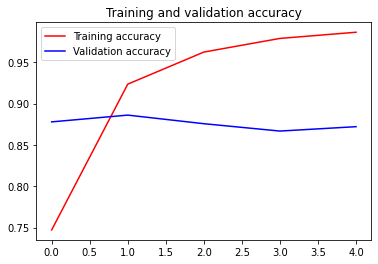

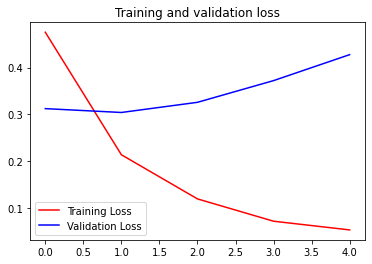

In [ ]:
data = load_dataset('IMDB Dataset.csv')
reviews, labels = clean_data(data)
reviews_train, reviews_test, labels_train, labels_test = split_dataset(reviews, labels)
max_len = get_max_length(reviews)
print(max_len)
print(type(reviews_train))
reviews_train, reviews_test, total_words = tokenize_pad_trunc(reviews_train, reviews_test)
print(total_words)
model = sentiment_classification_model(total_words, max_len)
checkpoint = checkpoint_model()
history = history = model.fit(reviews_train, labels_train, validation_data = (reviews_test, labels_test), batch_size = 128, epochs = 5, callbacks=[checkpoint])
plot_training(history)


In [ ]:
model.fit(reviews_train, labels_train, batch_size = 128, epochs = 5)

Epoch 1/5
313/313 [==============================] - 11s 36ms/step - loss: 0.3113 - accuracy: 0.8673
Epoch 2/5
313/313 [==============================] - 11s 35ms/step - loss: 0.3055 - accuracy: 0.8680
Epoch 3/5
313/313 [==============================] - 11s 35ms/step - loss: 0.3016 - accuracy: 0.8709
Epoch 4/5
313/313 [==============================] - 11s 35ms/step - loss: 0.2950 - accuracy: 0.8739
Epoch 5/5
313/313 [==============================] - 11s 35ms/step - loss: 0.2886 - accuracy: 0.8763


In [ ]:
model.fit(reviews_train, labels_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.6901
Epoch 00001: accuracy improved from -inf to 0.69007, saving model to models/LSTM.h5
313/313 [==============================] - 11s 36ms/step - loss: 0.5413 - accuracy: 0.6901
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.9086
Epoch 00002: accuracy improved from 0.69007 to 0.90865, saving model to models/LSTM.h5
313/313 [==============================] - 11s 36ms/step - loss: 0.2487 - accuracy: 0.9086
Epoch 3/5
312/313 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9544
Epoch 00003: accuracy improved from 0.90865 to 0.95440, saving model to models/LSTM.h5
313/313 [==============================] - 11s 36ms/step - loss: 0.1439 - accuracy: 0.9544
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9754
Epoch 00004: accuracy improved from 0.95440 to 0.97545, saving model to models/LSTM.h5
31

In [ ]:
data = load_dataset('IMDB Dataset.csv')
reviews, labels = clean_data(data)
reviews_train, reviews_test, labels_train, labels_test = split_dataset(reviews, labels)
max_len = get_max_length(reviews)
print(max_len)
print(type(reviews_train))
reviews_train, reviews_test, total_words = tokenize_pad_trunc(reviews_train, reviews_test)
print(total_words)
model = sentiment_classification_model(total_words, max_len)

history = model.fit(reviews_train, labels_train, validation_data = (reviews_test, labels_test), batch_size = 128, epochs = 5, callbacks=[checkpoint])

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>
1725
176
130
<class 'pandas.core.series.Series'>
Encoded X Train
 [[  1 199   3 ...   0   0   0]
 [  8   3   1 ...   0   0   0]
 [142 198 6

In [ ]:
model.summary()

NameError: ignored

In [ ]:
model.fit(reviews_train, labels_train, batch_size= batch_size, epochs=epochs)

Epoch 1/10
313/313 [==============================] - 57s 183ms/step - loss: 0.6844 - accuracy: 0.5352
Epoch 2/10
313/313 [==============================] - 58s 185ms/step - loss: 0.6691 - accuracy: 0.5603
Epoch 3/10
313/313 [==============================] - 58s 187ms/step - loss: 0.6856 - accuracy: 0.5337
Epoch 4/10
313/313 [==============================] - 57s 184ms/step - loss: 0.6873 - accuracy: 0.5277
Epoch 5/10
313/313 [==============================] - 62s 198ms/step - loss: 0.6836 - accuracy: 0.5411
Epoch 6/10
313/313 [==============================] - 59s 189ms/step - loss: 0.5980 - accuracy: 0.6709
Epoch 7/10
313/313 [==============================] - 60s 191ms/step - loss: 0.5178 - accuracy: 0.7666
Epoch 8/10
313/313 [==============================] - 59s 188ms/step - loss: 0.5714 - accuracy: 0.7391
Epoch 9/10
313/313 [==============================] - 58s 187ms/step - loss: 0.6102 - accuracy: 0.6733
Epoch 10/10
313/313 [==============================] - 60s 191ms/step - l

In [ ]:
scores = model.evaluate(reviews_test, labels_test, verbose = 1)
print(scores[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.4954 - accuracy: 0.8653
0.8652999997138977
